The point of this project was to utilize more than just sequence data for protein classification. Standard apporaches use reccurrent neural networks on protein sequences to predict protein classification, but we went about trying to see if we could use other easily attainable features to aid with prediction. 

| Experimentation No | Input Data | Model |
| --- | ----------- | ---------- |
| 1 | Protein Sequence Character Embeddings and Numerical Data | Multi-Input LSTM Concatenated Model |
| 2 | Protein Sequence Frequency Vector Embedding and Numerical Data | Multi-Input LSTM Concatenated Model |
| 3 | Protein Sequence Character Embeddings and Numerical Data | Multi-Input LSTM On Top of CNN Concatenated Model |
| 4 | Protein Sequence Character Embeddings and Numerical Data | Multi-Input Deep Dense LSTM On Top of CNN with Concatenated Model |
| FINAL | Merged Protein Sequence Data and Numerical Data into Single Feature | Single-Input LSTM On Top of CNN Model |

**Please Note:**  *For convenience's sake, this notebook only includes the final approach*

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/protein-data-set/pdb_data_seq.csv
/kaggle/input/protein-data-set/pdb_data_no_dups.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. EDA and Data Preprocessing

In [3]:
seq = pd.read_csv('/kaggle/input/protein-data-set/pdb_data_seq.csv')
seq

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
...,...,...,...,...,...
467299,9XIA,A,MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...,388,Protein
467300,9XIM,A,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...,1572,Protein
467301,9XIM,B,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...,1572,Protein
467302,9XIM,C,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...,1572,Protein


In [4]:
NoDups = pd.read_csv('/kaggle/input/protein-data-set/pdb_data_no_dups.csv')
NoDups

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141396,9RUB,LYASE(CARBON-CARBON),X-RAY DIFFRACTION,Protein,932,2.60,101838.68,NaN,NaN,2.38,48.29,NaN,NaN,1991.0
141397,9TNA,T-RNA,X-RAY DIFFRACTION,NaN,0,NaN,24244.34,NaN,NaN,3.17,61.18,NaN,NaN,1986.0
141398,9WGA,LECTIN (AGGLUTININ),X-RAY DIFFRACTION,Protein,342,1.80,34270.22,NaN,NaN,2.50,50.76,NaN,NaN,1990.0
141399,9XIA,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,388,1.90,43542.29,NaN,NaN,2.79,55.93,NaN,NaN,1989.0


In [5]:
df = NoDups.merge(seq,how='inner',on='structureId').drop_duplicates(['structureId'])
df

,structureId,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,residueCount_y,macromoleculeType_y
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0,A,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0,A,CGCGAATTCGCG,24,DNA
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein
5,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0,A,CGCAAATTTGCG,24,DNA
7,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,Protein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471138,9RSA,HYDROLASE (PHOSPHORIC DIESTER),X-RAY DIFFRACTION,Protein,248,1.80,27987.16,NaN,NaN,2.25,45.45,NaN,NaN,1990.0,A,KETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTF...,248,Protein
471140,9RUB,LYASE(CARBON-CARBON),X-RAY DIFFRACTION,Protein,932,2.60,101838.68,NaN,NaN,2.38,48.29,NaN,NaN,1991.0,A,MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFA...,932,Protein
471142,9WGA,LECTIN (AGGLUTININ),X-RAY DIFFRACTION,Protein,342,1.80,34270.22,NaN,NaN,2.50,50.76,NaN,NaN,1990.0,A,ERCGEQGSNMECPNNLCCSQYGYCGMGGDYCGKGCQNGACWTSKRC...,342,Protein
471144,9XIA,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE),X-RAY DIFFRACTION,Protein,388,1.90,43542.29,NaN,NaN,2.79,55.93,NaN,NaN,1989.0,A,MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...,388,Protein


In [6]:
print(len(df))

140250


In [7]:
df.isnull().sum()

structureId                     0
classification                  2
experimentalTechnique           0
macromoleculeType_x          3064
residueCount_x                  0
resolution                  12504
structureMolecularWeight        0
crystallizationMethod       44531
crystallizationTempK        43738
densityMatthews             16298
densityPercentSol           16272
pdbxDetails                 22341
phValue                     35728
publicationYear             23518
chainId                         0
sequence                       28
residueCount_y                  0
macromoleculeType_y          3064
dtype: int64

In [8]:
len(df)

140250

In [9]:
df=df.dropna()
len(df)

65748

In [10]:
df = df[df['macromoleculeType_x'] == 'Protein']
print(len(df))
print(df)

60757
       structureId                            classification  \
324           1914                                ALU DOMAIN   
376           1A04               SIGNAL TRANSDUCTION PROTEIN   
441           1A0R         COMPLEX (TRANSDUCER/TRANSDUCTION)   
561           1A2B                          ONCOGENE PROTEIN   
601           1A2X  COMPLEX (SKELETAL MUSCLE/MUSCLE PROTEIN)   
...            ...                                       ...   
470383        6F6P                                 HYDROLASE   
470387        6F6S                             VIRAL PROTEIN   
470390        6F73                              FLAVOPROTEIN   
470396        6F8P                             VIRAL PROTEIN   
470473        6FAH                              FLAVOPROTEIN   

       experimentalTechnique macromoleculeType_x  residueCount_x  resolution  \
324        X-RAY DIFFRACTION             Protein             232        2.53   
376        X-RAY DIFFRACTION             Protein             430 

In [11]:
df=df.reset_index()
df

,index,structureId,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,residueCount_y,macromoleculeType_y
0,324,1914,ALU DOMAIN,X-RAY DIFFRACTION,Protein,232,2.53,26562.73,hanging drop,277.00,3.00,34.00,THE SRPPHI14-9 PROTEIN WAS CRYSTALLIZED (BIRSE...,7.7,1997.0,A,MASMTGGQQMGRIPGNSPRMVLLESEQFLTELTRLFQKCRSSGSVF...,232,Protein
1,376,1A04,SIGNAL TRANSDUCTION PROTEIN,X-RAY DIFFRACTION,Protein,430,2.20,47657.25,"VAPOR DIFFUSION, SITTING DROP",277.00,2.49,51.03,THE PROTEIN SOLUTION CONTAINING 23.3 MG/ML OF ...,7.6,1998.0,A,SNQEPATILLIDDHPMLRTGVKQLISMAPDITVVGEASNGEQGIEL...,430,Protein
2,441,1A0R,COMPLEX (TRANSDUCER/TRANSDUCTION),X-RAY DIFFRACTION,Protein,650,2.80,73467.70,MICROBATCH,277.00,2.25,45.00,THE PROTEIN COMPLEX (10 MG/ML SOLUTION) WAS CR...,6.8,1998.0,B,XSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...,650,Protein
3,561,1A2B,ONCOGENE PROTEIN,X-RAY DIFFRACTION,Protein,182,2.40,21160.17,"VAPOR DIFFUSION, HANGING DROP",277.00,2.77,56.00,CRYSTALS WERE OBTAINED AT 277 K BY THE HANGING...,8.5,1998.0,A,SMAAIRKKLVIVGDVACGKTCLLIVFSKDQFPEVYVPTVFENYVAD...,182,Protein
4,601,1A2X,COMPLEX (SKELETAL MUSCLE/MUSCLE PROTEIN),X-RAY DIFFRACTION,Protein,206,2.30,23608.14,"VAPOR DIFFUSION, HANGING DROP",289.00,2.30,35.00,HANGING-DROP VAPOR DIFFUSION METHOD WAS USED A...,8.0,1998.0,A,TDQQAEARSYLSEEMIAEFKAAFDMFDADGGGDISVKELGTVMRML...,206,Protein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60752,470383,6F6P,HYDROLASE,X-RAY DIFFRACTION,Protein,424,2.45,47994.95,VAPOR DIFFUSION,291.00,2.61,56.00,50 mM Tris pH 7.3 and 40% MPD,7.3,2018.0,A,GAASRLRSPSVLEVREKGYERLKEELAKAQRELKLKDEECERLSKV...,424,Protein
60753,470387,6F6S,VIRAL PROTEIN,X-RAY DIFFRACTION,Protein,497,2.29,58337.03,"VAPOR DIFFUSION, SITTING DROP",293.00,3.83,67.89,9% (W/V) PEG 6000 AND 0.1 M SODIUM CIT...,5.2,2018.0,A,ETGRSIPLGVIHNSALQVSDVDKLVCRDKLSSTNQLRSVGLNLEGN...,497,Protein
60754,470390,6F73,FLAVOPROTEIN,X-RAY DIFFRACTION,Protein,1148,2.22,128053.03,"VAPOR DIFFUSION, HANGING DROP",294.00,2.90,57.00,"20% PEG6000, , 0.2 M NaCl, 0.1 M NaAcetate pH 5.0",5.0,2018.0,A,MPASLLRFLALAGTAVGLTTNHNHSPSCRVLPGDAAWPSSRDWAKL...,1148,Protein
60755,470396,6F8P,VIRAL PROTEIN,X-RAY DIFFRACTION,Protein,316,1.60,34958.86,"VAPOR DIFFUSION, SITTING DROP",298.00,2.47,50.15,"20% w/v PEG 6000, 0.1 M HEPES pH 7.0",7.0,2018.0,A,EDPHLRNRPGKGHNYIDGMTQEDATCKPVTYAGACSSFDVLLEKGK...,316,Protein


In [12]:
df=df.drop(['index'],axis=1)
df

,structureId,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,residueCount_y,macromoleculeType_y
0,1914,ALU DOMAIN,X-RAY DIFFRACTION,Protein,232,2.53,26562.73,hanging drop,277.00,3.00,34.00,THE SRPPHI14-9 PROTEIN WAS CRYSTALLIZED (BIRSE...,7.7,1997.0,A,MASMTGGQQMGRIPGNSPRMVLLESEQFLTELTRLFQKCRSSGSVF...,232,Protein
1,1A04,SIGNAL TRANSDUCTION PROTEIN,X-RAY DIFFRACTION,Protein,430,2.20,47657.25,"VAPOR DIFFUSION, SITTING DROP",277.00,2.49,51.03,THE PROTEIN SOLUTION CONTAINING 23.3 MG/ML OF ...,7.6,1998.0,A,SNQEPATILLIDDHPMLRTGVKQLISMAPDITVVGEASNGEQGIEL...,430,Protein
2,1A0R,COMPLEX (TRANSDUCER/TRANSDUCTION),X-RAY DIFFRACTION,Protein,650,2.80,73467.70,MICROBATCH,277.00,2.25,45.00,THE PROTEIN COMPLEX (10 MG/ML SOLUTION) WAS CR...,6.8,1998.0,B,XSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...,650,Protein
3,1A2B,ONCOGENE PROTEIN,X-RAY DIFFRACTION,Protein,182,2.40,21160.17,"VAPOR DIFFUSION, HANGING DROP",277.00,2.77,56.00,CRYSTALS WERE OBTAINED AT 277 K BY THE HANGING...,8.5,1998.0,A,SMAAIRKKLVIVGDVACGKTCLLIVFSKDQFPEVYVPTVFENYVAD...,182,Protein
4,1A2X,COMPLEX (SKELETAL MUSCLE/MUSCLE PROTEIN),X-RAY DIFFRACTION,Protein,206,2.30,23608.14,"VAPOR DIFFUSION, HANGING DROP",289.00,2.30,35.00,HANGING-DROP VAPOR DIFFUSION METHOD WAS USED A...,8.0,1998.0,A,TDQQAEARSYLSEEMIAEFKAAFDMFDADGGGDISVKELGTVMRML...,206,Protein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60752,6F6P,HYDROLASE,X-RAY DIFFRACTION,Protein,424,2.45,47994.95,VAPOR DIFFUSION,291.00,2.61,56.00,50 mM Tris pH 7.3 and 40% MPD,7.3,2018.0,A,GAASRLRSPSVLEVREKGYERLKEELAKAQRELKLKDEECERLSKV...,424,Protein
60753,6F6S,VIRAL PROTEIN,X-RAY DIFFRACTION,Protein,497,2.29,58337.03,"VAPOR DIFFUSION, SITTING DROP",293.00,3.83,67.89,9% (W/V) PEG 6000 AND 0.1 M SODIUM CIT...,5.2,2018.0,A,ETGRSIPLGVIHNSALQVSDVDKLVCRDKLSSTNQLRSVGLNLEGN...,497,Protein
60754,6F73,FLAVOPROTEIN,X-RAY DIFFRACTION,Protein,1148,2.22,128053.03,"VAPOR DIFFUSION, HANGING DROP",294.00,2.90,57.00,"20% PEG6000, , 0.2 M NaCl, 0.1 M NaAcetate pH 5.0",5.0,2018.0,A,MPASLLRFLALAGTAVGLTTNHNHSPSCRVLPGDAAWPSSRDWAKL...,1148,Protein
60755,6F8P,VIRAL PROTEIN,X-RAY DIFFRACTION,Protein,316,1.60,34958.86,"VAPOR DIFFUSION, SITTING DROP",298.00,2.47,50.15,"20% w/v PEG 6000, 0.1 M HEPES pH 7.0",7.0,2018.0,A,EDPHLRNRPGKGHNYIDGMTQEDATCKPVTYAGACSSFDVLLEKGK...,316,Protein


In [13]:
count=0
for c in df.classification.values:
    if c=='OXYGEN TRANSPORT':
        count+=1
print(count)

125


In [14]:
print(df.residueCount_x.quantile(0.9))
df.residueCount_x.describe()

1479.4000000000015


count    60757.000000
mean       746.968102
std       1021.778816
min          5.000000
25%        285.000000
50%        468.000000
75%        846.000000
max      57792.000000
Name: residueCount_x, dtype: float64

In [15]:
df.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType_x', 'residueCount_x', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear', 'chainId', 'sequence',
       'residueCount_y', 'macromoleculeType_y'],
      dtype='object')

In [16]:
df = df.loc[df.residueCount_x<1200]
df.residueCount_x.describe()

count    51995.000000
mean       470.747841
std        272.199370
min          5.000000
25%        260.000000
50%        397.000000
75%        641.000000
max       1198.000000
Name: residueCount_x, dtype: float64

In [17]:
df.head()

,structureId,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,residueCount_y,macromoleculeType_y
0,1914,ALU DOMAIN,X-RAY DIFFRACTION,Protein,232,2.53,26562.73,hanging drop,277.0,3.00,34.00,THE SRPPHI14-9 PROTEIN WAS CRYSTALLIZED (BIRSE...,7.7,1997.0,A,MASMTGGQQMGRIPGNSPRMVLLESEQFLTELTRLFQKCRSSGSVF...,232,Protein
1,1A04,SIGNAL TRANSDUCTION PROTEIN,X-RAY DIFFRACTION,Protein,430,2.20,47657.25,"VAPOR DIFFUSION, SITTING DROP",277.0,2.49,51.03,THE PROTEIN SOLUTION CONTAINING 23.3 MG/ML OF ...,7.6,1998.0,A,SNQEPATILLIDDHPMLRTGVKQLISMAPDITVVGEASNGEQGIEL...,430,Protein
2,1A0R,COMPLEX (TRANSDUCER/TRANSDUCTION),X-RAY DIFFRACTION,Protein,650,2.80,73467.70,MICROBATCH,277.0,2.25,45.00,THE PROTEIN COMPLEX (10 MG/ML SOLUTION) WAS CR...,6.8,1998.0,B,XSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...,650,Protein
3,1A2B,ONCOGENE PROTEIN,X-RAY DIFFRACTION,Protein,182,2.40,21160.17,"VAPOR DIFFUSION, HANGING DROP",277.0,2.77,56.00,CRYSTALS WERE OBTAINED AT 277 K BY THE HANGING...,8.5,1998.0,A,SMAAIRKKLVIVGDVACGKTCLLIVFSKDQFPEVYVPTVFENYVAD...,182,Protein
4,1A2X,COMPLEX (SKELETAL MUSCLE/MUSCLE PROTEIN),X-RAY DIFFRACTION,Protein,206,2.30,23608.14,"VAPOR DIFFUSION, HANGING DROP",289.0,2.30,35.00,HANGING-DROP VAPOR DIFFUSION METHOD WAS USED A...,8.0,1998.0,A,TDQQAEARSYLSEEMIAEFKAAFDMFDADGGGDISVKELGTVMRML...,206,Protein


In [18]:
df['merge_col'] = list(map(lambda i : str(i['sequence']) + ' ' + str(i['residueCount_y'])+" "+str(i['phValue'])+" "+str(i['densityPercentSol'])+" "+str(i['macromoleculeType_y']) + " " + str(i['residueCount_x']) + " " + str(i['resolution']) + " " + str(i['crystallizationTempK']) + " " + str(i['chainId']) ,df.to_dict(orient="records") ))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df.describe()

,residueCount_x,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,phValue,publicationYear,residueCount_y
count,51995.000000,51995.000000,5.199500e+04,51995.000000,51995.000000,51995.000000,51995.000000,51995.000000,51995.000000
mean,470.747841,2.059800,5.462662e+04,291.026624,2.619671,50.643860,6.782645,2010.261448,470.747841
std,272.199370,0.512593,6.891665e+04,9.202631,0.679240,9.854144,1.333449,4.964020,272.199370
min,5.000000,0.480000,4.885400e+02,4.000000,0.000000,0.000000,0.000000,1986.000000,5.000000
25%,260.000000,1.700000,2.980115e+04,290.000000,2.190000,43.740000,6.000000,2007.000000,260.000000
50%,397.000000,2.000000,4.524095e+04,293.000000,2.440000,49.580000,7.000000,2011.000000,397.000000
75%,641.000000,2.370000,7.266917e+04,295.000000,2.850000,56.760000,7.500000,2014.000000,641.000000
max,1198.000000,8.490000,5.994845e+06,398.000000,12.700000,90.330000,100.000000,2018.000000,1198.000000


In [20]:
df.head()

,structureId,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,residueCount_y,macromoleculeType_y,merge_col
0,1914,ALU DOMAIN,X-RAY DIFFRACTION,Protein,232,2.53,26562.73,hanging drop,277.0,3.00,34.00,THE SRPPHI14-9 PROTEIN WAS CRYSTALLIZED (BIRSE...,7.7,1997.0,A,MASMTGGQQMGRIPGNSPRMVLLESEQFLTELTRLFQKCRSSGSVF...,232,Protein,MASMTGGQQMGRIPGNSPRMVLLESEQFLTELTRLFQKCRSSGSVF...
1,1A04,SIGNAL TRANSDUCTION PROTEIN,X-RAY DIFFRACTION,Protein,430,2.20,47657.25,"VAPOR DIFFUSION, SITTING DROP",277.0,2.49,51.03,THE PROTEIN SOLUTION CONTAINING 23.3 MG/ML OF ...,7.6,1998.0,A,SNQEPATILLIDDHPMLRTGVKQLISMAPDITVVGEASNGEQGIEL...,430,Protein,SNQEPATILLIDDHPMLRTGVKQLISMAPDITVVGEASNGEQGIEL...
2,1A0R,COMPLEX (TRANSDUCER/TRANSDUCTION),X-RAY DIFFRACTION,Protein,650,2.80,73467.70,MICROBATCH,277.0,2.25,45.00,THE PROTEIN COMPLEX (10 MG/ML SOLUTION) WAS CR...,6.8,1998.0,B,XSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...,650,Protein,XSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...
3,1A2B,ONCOGENE PROTEIN,X-RAY DIFFRACTION,Protein,182,2.40,21160.17,"VAPOR DIFFUSION, HANGING DROP",277.0,2.77,56.00,CRYSTALS WERE OBTAINED AT 277 K BY THE HANGING...,8.5,1998.0,A,SMAAIRKKLVIVGDVACGKTCLLIVFSKDQFPEVYVPTVFENYVAD...,182,Protein,SMAAIRKKLVIVGDVACGKTCLLIVFSKDQFPEVYVPTVFENYVAD...
4,1A2X,COMPLEX (SKELETAL MUSCLE/MUSCLE PROTEIN),X-RAY DIFFRACTION,Protein,206,2.30,23608.14,"VAPOR DIFFUSION, HANGING DROP",289.0,2.30,35.00,HANGING-DROP VAPOR DIFFUSION METHOD WAS USED A...,8.0,1998.0,A,TDQQAEARSYLSEEMIAEFKAAFDMFDADGGGDISVKELGTVMRML...,206,Protein,TDQQAEARSYLSEEMIAEFKAAFDMFDADGGGDISVKELGTVMRML...


In [21]:
from collections import Counter

In [22]:
uniqueC=0
uniqueL=[]
for c in df.classification:
    if c not in uniqueL:
        uniqueL.append(c)
        uniqueC+=1
print(uniqueC)

1893


In [23]:
df.classification.nunique()

1893

In [24]:
# count numbers of instances per class
cnt = Counter(df.classification)
# select only K most common classes! - was 10 by default
top_classes = 10
# sort classes
sorted_classes = cnt.most_common()[:top_classes]
classes = [c[0] for c in sorted_classes]
counts = [c[1] for c in sorted_classes]
print("at least " + str(counts[-1]) + " instances per class")

# apply to dataframe
print(str(df.shape[0]) + " instances before")
df = df[[c in classes for c in df.classification]]
print(str(df.shape[0]) + " instances after")

seqs = df['merge_col']
lengths = [len(s) for s in seqs]

at least 1147 instances per class
51995 instances before
30867 instances after


In [25]:
len(df.classification.value_counts())

10

In [26]:
df.classification.value_counts()

HYDROLASE                            8916
TRANSFERASE                          6549
OXIDOREDUCTASE                       4664
IMMUNE SYSTEM                        2098
LYASE                                1861
TRANSCRIPTION                        1605
TRANSPORT PROTEIN                    1454
HYDROLASE/HYDROLASE INHIBITOR        1356
SIGNALING PROTEIN                    1217
TRANSFERASE/TRANSFERASE INHIBITOR    1147
Name: classification, dtype: int64

In [27]:
df.head()

,structureId,classification,experimentalTechnique,macromoleculeType_x,residueCount_x,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence,residueCount_y,macromoleculeType_y,merge_col
6,1A72,OXIDOREDUCTASE,X-RAY DIFFRACTION,Protein,374,2.60,40658.50,"VAPOR DIFFUSION, HANGING DROP",277.0,2.30,46.82,CRYSTALS GROWN FROM 4 MICROLITER HANGING DROPS...,8.40,1998.0,A,STAGKVIKCKAAVLWEEKKPFSIEEVEVAPPKAHEVRIKMVATGIC...,374,Protein,STAGKVIKCKAAVLWEEKKPFSIEEVEVAPPKAHEVRIKMVATGIC...
16,1AR4,OXIDOREDUCTASE,X-RAY DIFFRACTION,Protein,402,1.90,45428.53,microseeding,277.0,2.05,32.00,PROTEIN WAS CRYSTALLIZED AT 50MG/ML FROM 2.15 ...,6.10,1996.0,A,AVYTLPELPYDYSALEPYISGEIMELHHDKHHKAYVDGANTALDKL...,402,Protein,AVYTLPELPYDYSALEPYISGEIMELHHDKHHKAYVDGANTALDKL...
17,1AR5,OXIDOREDUCTASE,X-RAY DIFFRACTION,Protein,402,1.60,45430.34,microseeding,277.0,2.04,32.20,PROTEIN WAS CRYSTALLIZED FROM 2.15 M (NH4)2SO4...,6.15,1996.0,A,AVYTLPELPYDYSALEPYISGEIMELHHDKHHKAYVDGANTALDKL...,402,Protein,AVYTLPELPYDYSALEPYISGEIMELHHDKHHKAYVDGANTALDKL...
19,1AUE,TRANSFERASE,X-RAY DIFFRACTION,Protein,200,2.33,24203.73,"VAPOR DIFFUSION, HANGING DROP",277.0,2.25,45.00,"HANGING DROPS AT 4 C, pH 8.0, vapor diffusion ...",8.00,1997.0,A,ELIRVAILWHEMWHEGLEEASRLYFGERNVKGMFEVLEPLHAMMER...,200,Protein,ELIRVAILWHEMWHEGLEEASRLYFGERNVKGMFEVLEPLHAMMER...
20,1AUK,HYDROLASE,X-RAY DIFFRACTION,Protein,489,2.10,52423.45,"VAPOR DIFFUSION, HANGING DROP",291.0,3.30,63.00,PROTEIN WAS CRYSTALLIZED BY VAPOR DIFFUSION IN...,5.40,1998.0,A,RPPNIVLIFADDLGYGDLGCYGHPSSTTPNLDQLAAGGLRFTDFYV...,489,Protein,RPPNIVLIFADDLGYGDLGCYGHPSSTTPNLDQLAAGGLRFTDFYV...


In [28]:
df.columns

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType_x', 'residueCount_x', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear', 'chainId', 'sequence',
       'residueCount_y', 'macromoleculeType_y', 'merge_col'],
      dtype='object')

# Data Preparation

In [29]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y = lb.fit_transform(df.classification)

In [30]:
X=df.drop('classification',axis=1)

In [31]:
df.iloc[0]['merge_col']

'STAGKVIKCKAAVLWEEKKPFSIEEVEVAPPKAHEVRIKMVATGICRSDDHVVSGTLVTPLPVIAGHEAAGIVESIGEGVTTVRPGDKVIPLWTPQCGKCRVCKHPEGNFCLKNDLSMPRGTMQDGTSRFTCRGKPIHHFLGTSTFSQYTVVDEISVAKIDAASPLEKVCLIGCGFSTGYGSAVKVAKVTQGSTCAVFGLGGAGLSVIMGCKAAGAARIIGVDINKDKFAKAKEVGATECVNPQDYKKPIQEVLTEMSNGGVDFSFEVIGRLDTMVTALSCCQEAYGVSVIVGVPPDSQNLSMNPMLLLSGRTWKGAIFGGFKSKDSVPKLVADFMAKKFALDPLITHVLPFEKINEGFDLLRSGESIRTILTF 374 8.4 46.82 Protein 374 2.6 277.0 A'

In [32]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

max_length = max(lengths)

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(seqs)

X_seq = tokenizer.texts_to_sequences(seqs)
X_seq = sequence.pad_sequences(X_seq, maxlen=max_length)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30867 entries, 6 to 60752
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   structureId               30867 non-null  object 
 1   classification            30867 non-null  object 
 2   experimentalTechnique     30867 non-null  object 
 3   macromoleculeType_x       30867 non-null  object 
 4   residueCount_x            30867 non-null  int64  
 5   resolution                30867 non-null  float64
 6   structureMolecularWeight  30867 non-null  float64
 7   crystallizationMethod     30867 non-null  object 
 8   crystallizationTempK      30867 non-null  float64
 9   densityMatthews           30867 non-null  float64
 10  densityPercentSol         30867 non-null  float64
 11  pdbxDetails               30867 non-null  object 
 12  phValue                   30867 non-null  float64
 13  publicationYear           30867 non-null  float64
 14  chainI

In [34]:
from tensorflow.keras.models import Sequential
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers.merge import Concatenate
from tensorflow.keras.layers import Dense,Dot,Conv1D,MaxPooling1D,Activation,Dropout,LSTM,Flatten,GlobalMaxPooling1D,Input

In [35]:
print(tokenizer.__dict__)

{'word_counts': OrderedDict([('s', 608270), ('t', 556955), ('a', 770619), ('g', 706994), ('k', 532725), ('v', 646185), ('i', 546298), ('c', 138415), ('l', 862024), ('w', 148253), ('e', 630336), ('p', 490574), ('f', 386257), ('h', 274020), ('r', 503786), ('m', 220809), ('d', 544330), ('q', 355435), ('n', 425921), ('y', 342672), (' ', 246936), ('3', 49648), ('7', 46614), ('4', 52965), ('8', 48892), ('.', 123468), ('6', 48166), ('2', 85160), ('o', 30879), ('0', 68944), ('1', 52283), ('9', 52774), ('5', 62708), ('u', 14), ('x', 1319), ('b', 125), ('z', 23), ('j', 2)]), 'word_docs': defaultdict(<class 'int'>, {'v': 30754, 'r': 30867, 'n': 30867, '3': 23002, '0': 30550, '7': 22050, '8': 23134, 'f': 30697, 'k': 30743, 't': 30867, 'g': 30805, 'o': 30867, 'e': 30867, '4': 23985, 'y': 30625, 'a': 30859, 'h': 30339, 'p': 30867, 'w': 28303, 'c': 27040, '2': 30779, 'i': 30867, 'q': 30566, 's': 30691, 'd': 30809, '.': 30867, 'm': 29869, 'l': 30833, '6': 22963, ' ': 30867, '1': 24604, '9': 27793, '5'

In [36]:
tokenizer.word_index

{'l': 1,
 'a': 2,
 'g': 3,
 'v': 4,
 'e': 5,
 's': 6,
 't': 7,
 'i': 8,
 'd': 9,
 'k': 10,
 'r': 11,
 'p': 12,
 'n': 13,
 'f': 14,
 'q': 15,
 'y': 16,
 'h': 17,
 ' ': 18,
 'm': 19,
 'w': 20,
 'c': 21,
 '.': 22,
 '2': 23,
 '0': 24,
 '5': 25,
 '4': 26,
 '9': 27,
 '1': 28,
 '3': 29,
 '8': 30,
 '6': 31,
 '7': 32,
 'o': 33,
 'x': 34,
 'b': 35,
 'z': 36,
 'u': 37,
 'j': 38}

In [37]:
# def vector_based_on_freq(sequence):
#     vector = []
#     for i in tokenizer.word_index.keys():
#         i=i.upper()
#         vector.append(sequence.count(i)/len(sequence))
    
#     return(vector)

In [38]:
tokenizer.word_index.keys()

dict_keys(['l', 'a', 'g', 'v', 'e', 's', 't', 'i', 'd', 'k', 'r', 'p', 'n', 'f', 'q', 'y', 'h', ' ', 'm', 'w', 'c', '.', '2', '0', '5', '4', '9', '1', '3', '8', '6', '7', 'o', 'x', 'b', 'z', 'u', 'j'])

In [39]:
# vector_based_on_freq(df.iloc[0]['sequence'])

In [40]:
# df['frequency_vector'] = df['sequence'].apply(lambda i : vector_based_on_freq(i))

In [41]:
# X_rest = df.drop(['sequence','classification','macromoleculeType_x','structureId',
#                  'experimentalTechnique','crystallizationMethod','pdbxDetails',
#                  'chainId','macromoleculeType_y','frequency_vector'],axis=1)

In [42]:
# X_rest = df.drop(['sequence','classification','macromoleculeType_x','structureId',
#                  'experimentalTechnique','crystallizationMethod','pdbxDetails',
#                  'chainId','macromoleculeType_y','publicationYear'],axis=1)

In [43]:
# X_rest.head()

In [44]:
# X_seq = df['frequency_vector']

# Final Model

In [45]:
input_1 = Input(shape=(max_length,)) #sequence

In [46]:
embedding_layer = Embedding(len(tokenizer.word_index)+1, 8)(input_1)
CNN_Layer_pre = Conv1D(filters=64,kernel_size=6,padding='same',activation='relu')(embedding_layer)
CNN_layer = Conv1D(filters=32,kernel_size=3,padding='same',activation='relu')(CNN_Layer_pre)
MaxPooling_layer = MaxPooling1D(pool_size=2)(CNN_layer)
LSTM_Layer_1 = LSTM(150)(MaxPooling_layer)
#concat_layer = Concatenate()([LSTM_Layer_1, input_2])
#dense_Concat = Dense(100,activation='relu')(concat_layer)
#dense_Concat_2 = Dense(100,activation='relu')(dense_Concat)

In [47]:
# dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(top_classes, activation='softmax')(LSTM_Layer_1)
model = Model(inputs=input_1, outputs=output)

# A Prototype Model 

In [48]:
# input_1 = Input(shape=(25,)) #sequence

In [49]:
# input_2 = Input(shape=(len(X_rest.columns),)) #rest

In [50]:
# concat_layer = Concatenate()([input_1, input_2])
# dense_layer_3 = Dense(10, activation='relu')(concat_layer)
# output = Dense(top_classes, activation='softmax')(dense_layer_3)
# model = Model(inputs=[input_1, input_2], outputs=output)

# Training and Testing Model

In [51]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1174)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1174, 8)           312       
_________________________________________________________________
conv1d (Conv1D)              (None, 1174, 64)          3136      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1174, 32)          6176      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 587, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 150)               109800    
_________________________________________________________________
dense (Dense)                (None, 10)               

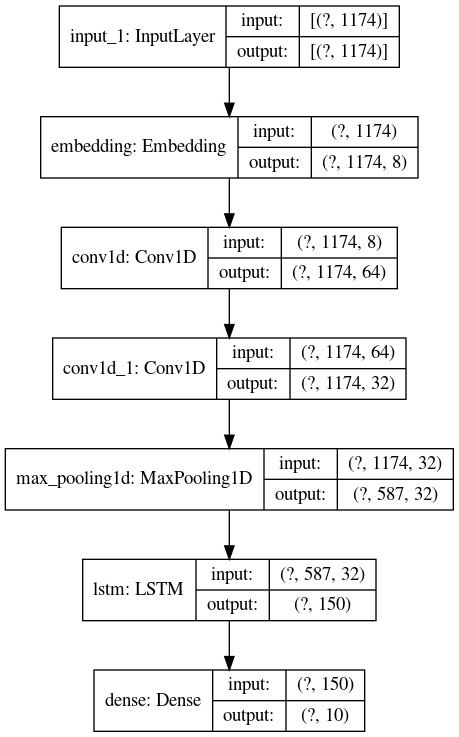

In [52]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [53]:
X_seq = np.array(X_seq)

In [54]:
X_seq = np.array(list(X_seq))

In [55]:
msk = np.random.rand(len(df)) < 0.8

In [56]:
X_seq_train = X_seq[msk]
# X_rest_train = X_rest[msk]
y_train = y[msk]

X_seq_test = X_seq[~msk]
# X_rest_test = X_rest[~msk]
y_test = y[~msk]

In [57]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [58]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [59]:
best_model_save = ModelCheckpoint(
    '/kaggle/working/best_model.h5', monitor='val_acc', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto'
)


In [60]:
history = model.fit(x=X_seq_train, y=y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2,callbacks=[best_model_save])

Epoch 1/15
155/155 [==============================] - ETA: 0s - loss: 2.0232 - acc: 0.2848
Epoch 00001: val_acc improved from -inf to 0.29193, saving model to /kaggle/working/best_model.h5
155/155 [==============================] - 11s 71ms/step - loss: 2.0232 - acc: 0.2848 - val_loss: 2.0438 - val_acc: 0.2919
Epoch 2/15
154/155 [============================>.] - ETA: 0s - loss: 1.9991 - acc: 0.2918
Epoch 00002: val_acc improved from 0.29193 to 0.31094, saving model to /kaggle/working/best_model.h5
155/155 [==============================] - 10s 66ms/step - loss: 1.9991 - acc: 0.2918 - val_loss: 1.9975 - val_acc: 0.3109
Epoch 3/15
154/155 [============================>.] - ETA: 0s - loss: 1.9491 - acc: 0.3122
Epoch 00003: val_acc improved from 0.31094 to 0.32329, saving model to /kaggle/working/best_model.h5
155/155 [==============================] - 10s 66ms/step - loss: 1.9484 - acc: 0.3122 - val_loss: 1.9601 - val_acc: 0.3233
Epoch 4/15
154/155 [============================>.] - ETA:

In [61]:
import tensorflow as tf
best_model = tf.keras.models.load_model('/kaggle/working/best_model.h5')

In [62]:
from sklearn.metrics import confusion_matrix
y_test_pred = best_model.predict(X_seq_test)
confusionMatrix = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_test_pred,axis=1))

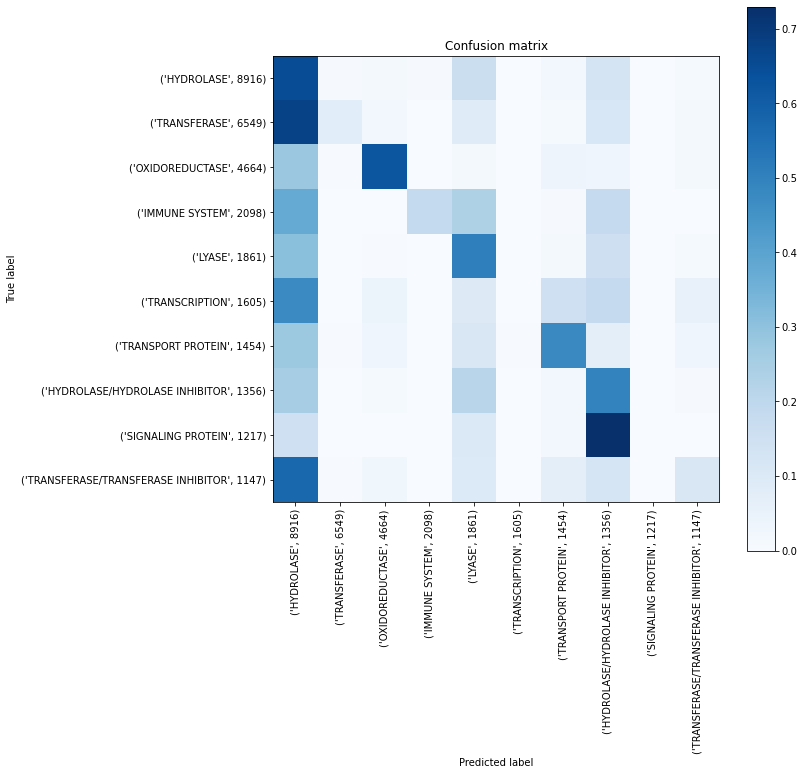

array([[0.65, 0.01, 0.02, 0.01, 0.16, 0.  , 0.02, 0.13, 0.  , 0.01],
       [0.68, 0.08, 0.02, 0.  , 0.09, 0.  , 0.01, 0.11, 0.  , 0.02],
       [0.28, 0.  , 0.62, 0.  , 0.01, 0.  , 0.03, 0.03, 0.  , 0.01],
       [0.38, 0.  , 0.  , 0.19, 0.24, 0.  , 0.01, 0.18, 0.  , 0.  ],
       [0.31, 0.  , 0.  , 0.  , 0.51, 0.  , 0.02, 0.15, 0.  , 0.01],
       [0.48, 0.  , 0.04, 0.  , 0.1 , 0.  , 0.15, 0.18, 0.  , 0.05],
       [0.27, 0.  , 0.03, 0.  , 0.11, 0.  , 0.48, 0.07, 0.  , 0.03],
       [0.25, 0.  , 0.01, 0.  , 0.21, 0.  , 0.02, 0.5 , 0.  , 0.01],
       [0.15, 0.  , 0.  , 0.  , 0.1 , 0.  , 0.02, 0.73, 0.  , 0.  ],
       [0.57, 0.  , 0.03, 0.  , 0.1 , 0.  , 0.07, 0.12, 0.  , 0.11]])

In [63]:
# Plot normalized confusion matrix
confusionMatrix = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(confusionMatrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(top_classes)
plt.xticks(tick_marks, sorted_classes, rotation=90)
plt.yticks(tick_marks, sorted_classes)
#for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#    plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

confusionMatrix

In [64]:
#References
#https://towardsdatascience.com/a-comprehensive-guide-to-correlational-neural-network-with-keras-3f7886028e4a
#https://snap.stanford.edu/snappy/doc/reference/multimodal.html
#https://openaccess.thecvf.com/content_cvpr_2017/papers/Chen_AMC_Attention_guided_CVPR_2017_paper.pdf

# References
https://towardsdatascience.com/a-comprehensive-guide-to-correlational-neural-network-with-keras-3f7886028e4a

https://snap.stanford.edu/snappy/doc/reference/multimodal.html

https://openaccess.thecvf.com/content_cvpr_2017/papers/Chen_AMC_Attention_guided_CVPR_2017_paper.pdf